In [1]:
from scipy.stats import shapiro 
import pandas as pd
import math
import pingouin as pg
from scipy import stats
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Probit
from statsmodels.tools import add_constant
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
!pip install pingouin -q

In [3]:
df = pd.read_csv('mosleh_et_al_data.csv')

# Twitter Suspensions after the 2020 Election

We will use the Chi-square test of independence to find out whether the sharing of one of the hashtags #VoteBidenHarris2020, #Trump2020 influences the suspension of an account. 
* Null hypothesis (H0): the suspension of an account and the hashtag shared are independent.
* Alternative hypothesis (HA): the suspension of an account and the hashtag shared are dependent.
<br> Significance level: 0.05

In [4]:
ct = pd.crosstab(df['politics_hashtag'], df['suspended'])
ct.index = ['#VoteBidenHarris2020', '#Trump2020']
ct.columns = ['not suspended', 'suspended']
print(ct)

                      not suspended  suspended
#VoteBidenHarris2020           4295        200
#Trump2020                     3623        882


In [5]:
res = stats.chi2_contingency(ct)
res.pvalue

1.3808204811294585e-107

The p value is far less than the significance level (1.38×10^(-17)< 0.05) so the null hypothesis is rejected and we accept that the suspension of an account is influenced by the hashtag it has shared.

## Distributions of Relative Frequency of Low Quality

In [6]:
low_qual_hashtag = df[['politics_hashtag', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd']]
print(low_qual_hashtag.head())

   politics_hashtag  lowqual_pr2019_fc  lowqual_pr2019_crowd
0                 0           0.279221              0.598883
1                 1           0.848639              0.774873
2                 0           0.242347              0.548727
3                 0           0.360119              0.611501
4                 1           0.698661              0.700217


We standardize the low quality news sharing (columns lowqual_pr2019_fc and lowqual_pr2019_crowd) using z-scores in order to make the datapoints comparable.

In [7]:
standardized_low_qual = low_qual_hashtag[['lowqual_pr2019_fc', 'lowqual_pr2019_crowd']].apply(
    lambda x: (x - x.mean()) / x.std()
)

standardized_low_qual_hashtag = pd.concat([low_qual_hashtag['politics_hashtag'], standardized_low_qual], axis=1)
print(standardized_low_qual_hashtag.head())

   politics_hashtag  lowqual_pr2019_fc  lowqual_pr2019_crowd
0                 0          -0.782343             -0.541104
1                 1           1.597431              1.898497
2                 0          -0.936449             -1.236379
3                 0          -0.444244             -0.366194
4                 1           0.970625              0.863601


We plot the distributions of low-quality sharing as determined by professional fact-checkers based on the hashtag shared.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


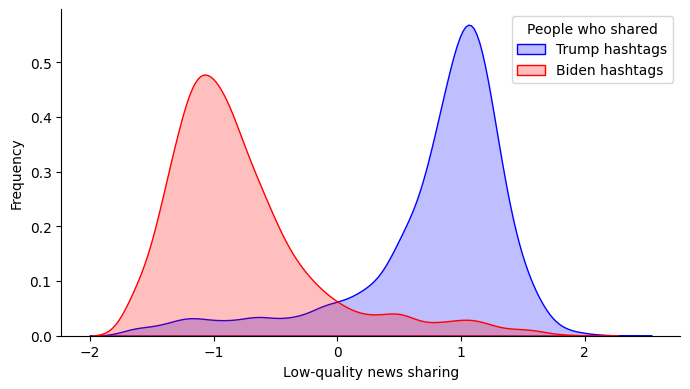

In [8]:
sns.displot(standardized_low_qual_hashtag, x="lowqual_pr2019_fc", hue="politics_hashtag", 
            kind="kde", fill=True, height=4, aspect=1.75, legend=False, palette=["red", "blue"])
plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")
plt.legend(title="People who shared", labels=["Trump hashtags", "Biden hashtags"]) 

Then we plot the distributions of low-quality sharing as determined by crowdsourcing based on the hashtag shared.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


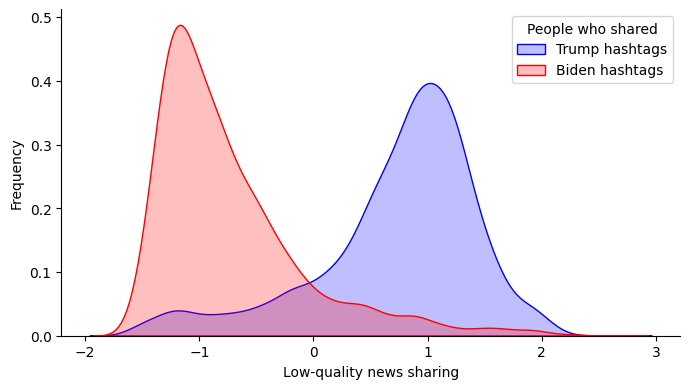

In [9]:
sns.displot(standardized_low_qual_hashtag, x="lowqual_pr2019_crowd", hue="politics_hashtag", 
            kind="kde", fill=True, height=4, aspect=1.75, legend=False, palette=["red", "blue"])
plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")
plt.legend(title="People who shared", labels=["Trump hashtags", "Biden hashtags"]) 

## Low-quality News Sharing on Twitter

We create 2 dataframes with low quality news sharing data, one of the group of users who have shared #VoteBidenHarris2020 and another one with the ones that have shared #Trump2020.

In [10]:
lowqual_df = df[['politics_hashtag', 'lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_mbfc', 
                 'lowqual_lasser2019', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep']]
lowqual_biden = lowqual_df[lowqual_df['politics_hashtag'] == 0]
lowqual_trump = lowqual_df[lowqual_df['politics_hashtag'] == 1]

We will perform an independent-samples one-tailed t-test since the groups come from two independent populations (users who tweet the hashtag #VoteBidenHarris2020 and users who tweet the #Trump2020) and we want to check whether the quality news sharing of one is worse than the other.

* Null hypothesis (H0): the low quality mean of tweets with #VoteBidenHarris2020 is greater than or equal to the one of #Trump2020.
* Alternative hypothesis (HA): the low quality mean of tweets with #VoteBidenHarris2020 is less than the one of #Trump2020

In [11]:
#exclude first column (politics_hashtag) and perform t-tests on the rest
t_stats, p_values = stats.ttest_ind(lowqual_biden.iloc[:, 1:], lowqual_trump.iloc[:, 1:], 
                                    axis=0, nan_policy='omit')

results_df = pd.DataFrame({
    'T-statistic': t_stats,
    'P-value': p_values
}, index=lowqual_biden.columns[1:])

print(results_df)

                         T-statistic  P-value
lowqual_pr2019_fc        -119.223343      0.0
lowqual_afm              -102.677719      0.0
lowqual_mbfc              -97.592231      0.0
lowqual_lasser2019       -102.633746      0.0
lowqual_pr2019_crowd     -102.464014      0.0
lowqual_pr2019_crowdrep   -61.071485      0.0


The p-value being close to 0 indicates that there is enough evidence to reject the null hypothesis that the low quality mean of tweets with #VoteBidenHarris2020 is greater than the mean of #Trump2020. The large value of (the absolute value of) the t-statistic shows that the difference between the two means is larger than what would be expected by random variation.
<br> In other words, the quality of the tweets with #Trump2020 is far worse than the ones with #VoteBidenHarris2020.

The fact that the t-statistic of the sites rated by republicans (lowqual_pr2019_crowdrep) is not as large as the rest indicates that the republican participants didn't rate the quality of the sites of tweets with #Trump2020 as bad as all other participants.

In [12]:
biden = lowqual_biden['lowqual_pr2019_fc']
trump = lowqual_trump['lowqual_pr2019_fc']
biden = biden.dropna()
trump = trump.dropna()

In [13]:
data1 = lowqual_biden.iloc[:, 1:]
data2 = lowqual_trump.iloc[:, 1:]

In [14]:
cohens_d_values = []
hedges_g_values = []

for col1, col2 in zip(data1.columns, data2.columns):
    #data of the current column pair
    col_data1 = data1[col1].dropna()
    col_data2 = data2[col2].dropna()
    
    #sample sizes
    n1 = len(col_data1)
    n2 = len(col_data2)
    
    #means and standard deviations
    mean1 = col_data1.mean()
    mean2 = col_data2.mean()
    std1 = col_data1.std(ddof=1)
    std2 = col_data2.std(ddof=1)
    
    #pooled standard deviation
    pooled_std = math.sqrt(((std1 ** 2) * (n1 - 1) + (std2 ** 2) * (n2 - 1)) / (n1 + n2 - 2))
    
    #cohen's d
    cohens_d = (mean1 - mean2) / pooled_std
    cohens_d_values.append(cohens_d)
    
    #hedges' g
    hedges_correction = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g = cohens_d * hedges_correction
    hedges_g_values.append(hedges_g)

results = pd.DataFrame({
    'Column': data1.columns,
    'Cohen\'s d': cohens_d_values,
    'Hedges\' g': hedges_g_values
})

print(results)

                    Column  Cohen's d  Hedges' g
0        lowqual_pr2019_fc  -2.521188  -2.520977
1              lowqual_afm  -2.164878  -2.164698
2             lowqual_mbfc  -2.057540  -2.057369
3       lowqual_lasser2019  -2.163831  -2.163650
4     lowqual_pr2019_crowd  -2.166782  -2.166601
5  lowqual_pr2019_crowdrep  -1.291464  -1.291356


The Cohen's d metric being greater than 1.2 and in most cases greater than 2 indicates that the difference of the means of the two groups is extremely large. <br>
Same goes with the Hedge's g value that is almost the same as the Cohen's d, indicating again that the difference is very large.

### Sharing Lower-quality News Sources and Conservative Ideology

We first drop the rows with NaN values.

In [15]:
d = df[['lowqual_pr2019_fc', 'lowqual_lasser2019', 'lowqual_mbfc',
        'lowqual_afm', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep', 
        'politics_followed', 'politics_hashtag', 'politics_sites1', 'politics_sites2']]
d = d.dropna()

Pairwise correlation requires the data to be normally distributed.<br> In order to check whether it is, we will perform a Shapiro-Wilk Test first on the low quality columns and then on the politics ones.

* Null hypothesis (H0): the sample stems from a normal distribution (Po>0.05)
* Alternative hypothesis (HA): the sample doesn't stem from a normal distribution

In [16]:
shapiro_pvalue = d.apply(lambda x: shapiro(x)[1])
print(shapiro_pvalue)

lowqual_pr2019_fc          0.000000e+00
lowqual_lasser2019         0.000000e+00
lowqual_mbfc               0.000000e+00
lowqual_afm                0.000000e+00
lowqual_pr2019_crowd       0.000000e+00
lowqual_pr2019_crowdrep    4.063215e-39
politics_followed          0.000000e+00
politics_hashtag           0.000000e+00
politics_sites1            0.000000e+00
politics_sites2            0.000000e+00
dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The p-values are 0 (or close to zero) which is less than the threshold (0.05), so we accept the null hypothesis that the sample doesn't come from a normal distribution.

We will perform the Min-max normalization on all the columns. The politics_hashtag column will stay the same after the scaling since its values are only 0 and 1.

In [17]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(d)
scaled_df = pd.DataFrame(scaled_df, columns=d.columns)

Then we perform Pearson pairwise correlations between the different low quality rates and the political ideology.

In [18]:
#compute correlation between the two groups
correlation_results = pg.pairwise_corr(scaled_df, columns=[['lowqual_pr2019_fc', 'lowqual_lasser2019', 
                                                            'lowqual_mbfc','lowqual_afm', 'lowqual_pr2019_crowd', 
                                                            'lowqual_pr2019_crowdrep'], None], method='pearson')

results = correlation_results[['X','Y','r']]

corr_matrix = results.pivot(index='X', columns='Y', values='r')
corr_matrix = corr_matrix.reindex(['lowqual_pr2019_fc', 'lowqual_lasser2019', 'lowqual_mbfc', 
                                   'lowqual_afm', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep'])
print(corr_matrix)

Y                        politics_followed  politics_hashtag  politics_sites1  \
X                                                                               
lowqual_pr2019_fc                 0.809501          0.834399         0.881741   
lowqual_lasser2019                0.778608          0.789910         0.847847   
lowqual_mbfc                      0.751176          0.764296         0.795237   
lowqual_afm                       0.770694          0.790923         0.852068   
lowqual_pr2019_crowd              0.754001          0.783704         0.818824   
lowqual_pr2019_crowdrep           0.540993          0.580989         0.582345   

Y                        politics_sites2  
X                                         
lowqual_pr2019_fc               0.860975  
lowqual_lasser2019              0.863775  
lowqual_mbfc                    0.794058  
lowqual_afm                     0.841501  
lowqual_pr2019_crowd            0.793501  
lowqual_pr2019_crowdrep         0.560976  


Lastly we display the results in a heatmap.

Text(50.5815972222222, 0.5, '')

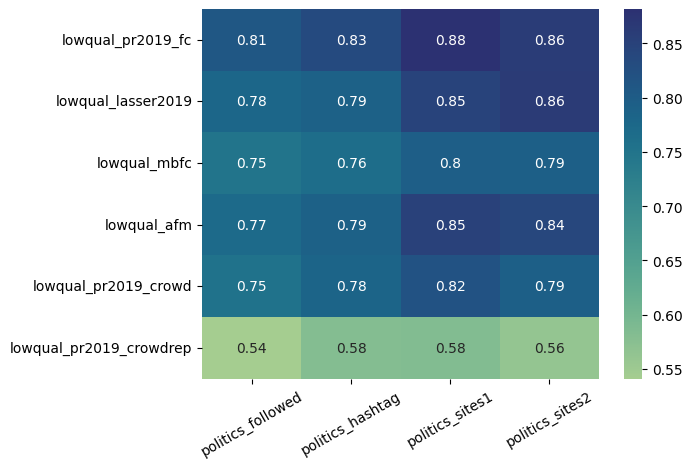

In [19]:
sns.heatmap(corr_matrix, annot=True, cmap="crest")
plt.xticks(rotation=30, ha='center')
plt.xlabel('')
plt.ylabel('') 

## News Sharing Can Help Explain Suspension, Using Single Predictors

In [20]:
d = df[["politics_hashtag", "politics_sites1", "politics_sites2", 
    "politics_followed", "lowqual_afm", "lowqual_mbfc", 
    "lowqual_lasser2019", "lowqual_pr2019_fc", "lowqual_pr2019_crowd", "suspended"]].dropna()

We first fit the probit model to each predictor and compute the AUC.

In [21]:
def fit_probit_and_calc_auc(X, y):
    model = Probit(y, add_constant(X)).fit(disp=0)  # Add constant for intercept
    y_pred = model.predict(add_constant(X))        # Predict probabilities
    fpr, tpr, _ = roc_curve(y, y_pred)
    return auc(fpr, tpr)

We bootstrap a resampling to estimate the AUC variability and we repeat 100 times to calculate the confidence intervals.

In [22]:
def bootstrap_auc(X, y, n_bootstraps=100, seed=42):
    rng = np.random.default_rng(seed)
    auc_scores = []

    for i in range(n_bootstraps):
        # Bootstrap resample
        X_resampled, y_resampled = resample(X, y, random_state=rng.integers(0, 10000))
        try:
            auc_score = fit_probit_and_calc_auc(X_resampled, y_resampled)
            auc_scores.append(auc_score)
        except Exception as e:
            print(f"Bootstrap {i} failed: {e}")

    # Confidence intervals
    lower_ci = np.percentile(auc_scores, 2.5)
    upper_ci = np.percentile(auc_scores, 97.5)
    mean_auc = np.mean(auc_scores)
    return mean_auc, lower_ci, upper_ci

We loop through this process for each predictor.

In [23]:
results = []

predictors = [
    "politics_hashtag", "politics_sites1", "politics_sites2", 
    "politics_followed", "lowqual_afm", "lowqual_mbfc", 
    "lowqual_lasser2019", "lowqual_pr2019_fc", "lowqual_pr2019_crowd"
]
for predictor in predictors:
    X_single = d[[predictor]]
    y = d["suspended"]
    mean_auc, lower_ci, upper_ci = bootstrap_auc(X_single, y)
    results.append({
        "Predictor": predictor,
        "Mean AUC": mean_auc,
        "CI Lower": lower_ci,
        "CI Upper": upper_ci
    })

results_df = pd.DataFrame(results)

print(results_df)

              Predictor  Mean AUC  CI Lower  CI Upper
0      politics_hashtag  0.697621  0.685142  0.710709
1       politics_sites1  0.716368  0.702715  0.732310
2       politics_sites2  0.722328  0.709458  0.737152
3     politics_followed  0.715483  0.699164  0.731315
4           lowqual_afm  0.734562  0.720304  0.748879
5          lowqual_mbfc  0.722609  0.707485  0.737129
6    lowqual_lasser2019  0.722574  0.707236  0.737675
7     lowqual_pr2019_fc  0.715387  0.700428  0.728416
8  lowqual_pr2019_crowd  0.702268  0.684874  0.715770


We create the plot that shows all our evaluations and the confidence intervals.

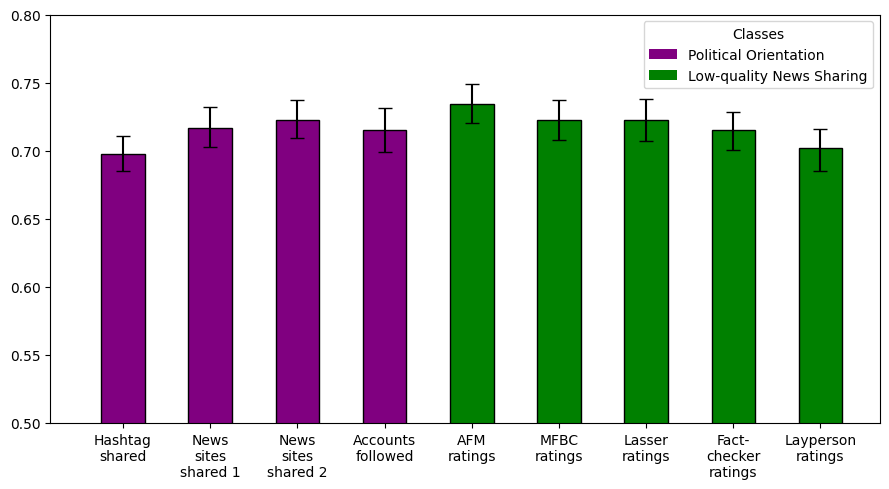

In [24]:
# Compute error margins
results_df['Error Lower'] = results_df['Mean AUC'] - results_df['CI Lower']
results_df['Error Upper'] = results_df['CI Upper'] - results_df['Mean AUC']

# Rename labels for x-axis
rename_dict = {
    "politics_hashtag": "Hashtag\nshared",
    "politics_sites1": "News\nsites\nshared 1",
    "politics_sites2": "News\nsites\nshared 2",
    "politics_followed": "Accounts\nfollowed",
    "lowqual_afm": "AFM\nratings",
    "lowqual_mbfc": "MFBC\nratings",
    "lowqual_lasser2019": "Lasser\nratings",
    "lowqual_pr2019_fc": "Fact-\nchecker\nratings",
    "lowqual_pr2019_crowd": "Layperson\nratings"
}
new_labels = [rename_dict[label] for label in results_df['Predictor']]

# Assign colors by class
classes = {
    "Political Orientation": ["politics_hashtag", "politics_sites1", "politics_sites2", "politics_followed"],
    "Low-quality News Sharing": ["lowqual_afm", "lowqual_mbfc", "lowqual_lasser2019", 
                                 "lowqual_pr2019_fc", "lowqual_pr2019_crowd"]
}

# Update lowqual_afm to be green (Low-quality News Sharing)
colors = results_df['Predictor'].apply(
    lambda x: "purple" if x in classes["Political Orientation"] else "green"
)

# Plotting
plt.figure(figsize=(9, 5))
bars = plt.bar(
    x=np.arange(len(results_df)), 
    height=results_df['Mean AUC'], 
    yerr=[results_df['Error Lower'].values, results_df['Error Upper'].values], 
    capsize=5, 
    color=colors,  # Set color based on the classes
    width=0.5,
    edgecolor='black'
)

# Customize y-axis
plt.ylim(0.50, 0.80)  # Set y-axis range
plt.yticks([0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80])  # Define tick marks

# Add legend
for label, color in zip(classes.keys(), ["purple", "green"]):
    plt.bar(0, 0, color=color, label=label)  # Dummy bars for legend
plt.legend(title="Classes", loc="upper right")

# Set the wrapped labels for the x-axis
plt.xticks(ticks=np.arange(len(results_df['Predictor'])), labels=new_labels)

plt.tight_layout()
plt.show()

## News Sharing Can Help Explain Suspension, Using Multiple Predictors

We fill in missing values of the dataframe using the mean of each column.

In [25]:
df_filled = df.fillna(df.mean())

We log-transform with base 10 the variables related to Tweeter metrics.

In [26]:
df_filled['log_repeated_tweet_count'] = np.where(df_filled['repeated_tweet_count'] > 0, 
                                            np.log10(df_filled['repeated_tweet_count']), 
                                            df_filled['repeated_tweet_count'])
df_filled['log_freq_pr_1h'] = np.where(df_filled['freq_pr_1h'] > 0, np.log10(df_filled['freq_pr_1h']), 
                                       df_filled['freq_pr_1h'])
df_filled['log_num_followers'] = np.where(df_filled['num_followers'] > 0, np.log10(df_filled['num_followers']), 
                                          df_filled['num_followers'])
df_filled['log_num_friends'] = np.where(df_filled['num_friends'] > 0, np.log10(df_filled['num_friends']), 
                                        df_filled['num_friends'])

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We compute the ratio of num_friends to num_followers, adding 1 to both variables to avoid zero or negative values.<br> We then apply the base 10 logarithm to the ratio and store the result in the new column log_fol.

In [27]:
df_filled['log_fol'] = np.log10((df_filled['num_friends'] + 1) / (df_filled['num_followers'] + 1))

We winsorize the following variables from both sides at the top 1% in order to reduce the effect of the outliers.

In [28]:
vars_to_winsorize = ['valence_neg', 'valence_neu', 'valence_pos', 'barbera_std', 'politics_sites1_std', 
                     'politics_sites2_ideo_std']
df_filled[vars_to_winsorize] = df_filled[vars_to_winsorize].apply(lambda x: mstats.winsorize \
                                                                  (x, limits=[0.01, 0.01]))


We winsorize the following variables only at the upper side at the top 1%.

In [29]:
vars_to_winsorize = ['moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent', 
           'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity', 
           'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat']
df_filled[vars_to_winsorize] = df_filled[vars_to_winsorize].apply(lambda x: mstats.winsorize(x, limits=[0, 0.01]))

Prior to PCA, we standardize the data because PCA is sensitive to the variances of the initial variables.

In [30]:
lowqual_columns = ['lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc']

scaler = StandardScaler()
lowqual_data = df_filled[lowqual_columns]
lowqual_data_scaled = scaler.fit_transform(lowqual_data)

We apply PCA to the standardized data, print out the explained variance ratio and then project the low quality news sharing dimensions to the new dimension: pc1_misinfo.

In [31]:
pca = PCA(n_components=1)
pc1_misinfo = pca.fit_transform(lowqual_data_scaled)

print("explained variance ratio:", pca.explained_variance_ratio_)

df_filled['pc1_misinfo'] = pc1_misinfo
print(df_filled[['pc1_misinfo']].head())

explained variance ratio: [0.87255953]
   pc1_misinfo
0    -1.643266
1     3.919070
2    -2.290660
3    -1.643703
4     2.426475


For the political orientation variables, prior to PCA again, we standardize the data.

In [32]:
politics_columns = ['politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2']

scaler = StandardScaler()
politics_data_scaled = scaler.fit_transform(df_filled[politics_columns])

We apply PCA to the standardized data, print out the explained variance ratio, calculate the absolute value of pc1_politics ('extremity') and then project the politics orientation dimensions to pc1_politics and extermity.

In [33]:
pca = PCA(n_components=1)
pc1_politics = pca.fit_transform(politics_data_scaled)

print("explained variance ratio:", pca.explained_variance_ratio_)

df_filled['pc1_politics'] = pc1_politics

df_filled['extremity'] = df_filled['pc1_politics'].abs()
print(df_filled[['pc1_politics', 'extremity']].head())

explained variance ratio: [0.87952937]
   pc1_politics  extremity
0     -1.841564   1.841564
1      2.264580   2.264580
2     -2.105501   2.105501
3     -1.836106   1.836106
4      2.648512   2.648512


We repeat the same steps with the following variables producing pc1_fol.

In [34]:
fol_columns = ['log_num_followers', 'log_num_friends', 'log_fol']

scaler = StandardScaler()
fol_data_scaled = scaler.fit_transform(df_filled[fol_columns])

pca = PCA(n_components=1)
pc1_fol = pca.fit_transform(fol_data_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

df_filled['pc1_fol'] = pc1_fol
print(df_filled[['pc1_fol']].head())

Explained variance ratio: [0.70390996]
    pc1_fol
0 -1.362274
1 -0.692696
2 -1.639964
3  3.316730
4 -0.583205


Regarding the harmful language variables, we will divide them into these 3 components:
* Abuse and Hate Speech: related to verbal abuse, hate speech, and harmful language targeted at individuals or groups<br>
rewire_abuse, rewire_hate, jigsaw_identity_attack, jigsaw_insult
* Profanity: profane language and insults that may not necessarily be hateful or abusive in a targeted way but still cause harm or disruption<br>
rewire_profanity, jigsaw_profanity
* Violence and Threats: more extreme forms of harmful language<br>
rewire_violent, rewire_sexually_explicit, jigsaw_threat, jigsaw_severe_toxicity

We repeat the same steps with the variables of the 3 components (pc1_harmful_language, pc2_harmful_language, pc3_harmful_language).

In [35]:
#pc1_harmful_language
harmful_language_columns = ['rewire_abuse', 'rewire_hate', 'jigsaw_idenity_attack', 'jigsaw_insult', 
                            'rewire_profanity', 'jigsaw_profanity', 'rewire_violent', 'rewire_sexually_explicit', 
                            'jigsaw_threat', 'jigsaw_severe_toxicity']

scaler = StandardScaler()
harmful_language_data_scaled = scaler.fit_transform(df_filled[harmful_language_columns[:4]])

pca = PCA(n_components=1)
pc1_harmful_language = pca.fit_transform(harmful_language_data_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

df_filled['pc1_harmful_language'] = pc1_harmful_language
print(df_filled[['pc1_harmful_language']].head())

Explained Variance Ratio: [0.70726106]
   pc1_harmful_language
0              2.084774
1              0.730039
2              1.380253
3              1.550408
4             -1.008364


In [36]:
#pc2_harmful_language
scaler = StandardScaler()
harmful_language_data_scaled = scaler.fit_transform(df_filled[harmful_language_columns[4:6]])

pca = PCA(n_components=1)
pc2_harmful_language = pca.fit_transform(harmful_language_data_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

df_filled['pc2_harmful_language'] = pc2_harmful_language
print(df_filled[['pc2_harmful_language']].head())

Explained Variance Ratio: [0.85674641]
   pc2_harmful_language
0              1.269029
1             -1.189528
2              1.503134
3              1.271417
4             -1.296354


In [37]:
#pc3_harmful_language
scaler = StandardScaler()
harmful_language_data_scaled = scaler.fit_transform(df_filled[harmful_language_columns[-4:]])

pca = PCA(n_components=1)
pc3_harmful_language = pca.fit_transform(harmful_language_data_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

df_filled['pc3_harmful_language'] = pc3_harmful_language
print(df_filled[['pc3_harmful_language']].head())

Explained Variance Ratio: [0.54014363]
   pc3_harmful_language
0             -0.115481
1              2.389359
2             -0.155135
3              0.481273
4             -1.324375


We repeat the same steps with the following variables producing pc1_valence.

In [38]:
valence_columns = ['valence_neg', 'valence_neu', 'valence_pos']

scaler = StandardScaler()
valence_data_scaled = scaler.fit_transform(df_filled[valence_columns])

pca = PCA(n_components=1)
pc1_valence = pca.fit_transform(valence_data_scaled)

print("Explained Variance Ratio", pca.explained_variance_ratio_)

df_filled['pc1_valence'] = pc1_valence

print(df_filled[['pc1_valence']].head())

Explained Variance Ratio [0.7079432]
   pc1_valence
0    -1.030499
1    -1.833775
2    -0.796028
3    -2.321373
4     1.005676


We normalize the following independent variables by taking their z-scores.

In [39]:
variables_to_normalize = [
    'pc1_politics', 'pc1_misinfo', 'pc1_fol',
    'pc1_harmful_language', 'pc2_harmful_language', 'pc3_harmful_language',
    'pc1_valence', 'tweets_in_2wk', 'botsentinel_score', 'extremity',
    'moral_outrage', 'liwc_political', 'log_freq_pr_1h',
    'log_repeated_tweet_count', 'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

df_filled[variables_to_normalize] = df_filled[variables_to_normalize].apply(
    lambda x: (x - x.mean()) / x.std(), axis=0
)

### Probit regression

We will perform probit regression to predict the variable suspended using all the variables/components we prepared.

In [40]:
# Define the dependent variable
y = df_filled['suspended']

# Define the independent variables (exclude 'suspension')
X = df_filled[variables_to_normalize]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the probit regression model
probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

print(probit_results.summary())

Optimization terminated successfully.
         Current function value: 0.303330
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.1743
Time:                        23:14:22   Log-Likelihood:                -2730.0
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                1.838e-234
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4244      0.023    -61.167      0.000      -1.470

Before interpreting the results, we will perform the Bonferroni and the Holm Bonferroni correction.

In [41]:
def bonferroni(results):
    # Extract p-values from the probit regression results
    p_values = results.pvalues

    # Perform Bonferroni correction
    _, bonferroni_corrected_p, _, _ = multipletests(p_values, method='bonferroni')

    # Perform Holm-Bonferroni correction
    _, holm_bonferroni_corrected_p, _, _ = multipletests(p_values, method='holm')

    results_df = pd.DataFrame({
        'Variable': probit_results.params.index,
        'P-Value': p_values,
        'Bonferroni': bonferroni_corrected_p,
        'Holm-Bonferroni': holm_bonferroni_corrected_p
    })

    results_df[['P-Value', 'Bonferroni', 'Holm-Bonferroni']] = \
        results_df[['P-Value', 'Bonferroni', 'Holm-Bonferroni']].apply(lambda col: col.map(lambda x: f"{x:.4f}"))
    df_sorted = results_df.sort_values(by='P-Value', ascending=False)
    
    return df_sorted

bonferroni(probit_results)

,Variable,P-Value,Bonferroni,Holm-Bonferroni
log_repeated_tweet_count,log_repeated_tweet_count,0.9795,1.0000,1.0000
pc1_fol,pc1_fol,0.9040,1.0000,1.0000
pc1_harmful_language,pc1_harmful_language,0.5346,1.0000,1.0000
politics_sites1_std,politics_sites1_std,0.2032,1.0000,1.0000
moral_outrage,moral_outrage,0.2015,1.0000,1.0000
liwc_political,liwc_political,0.1667,1.0000,1.0000
barbera_std,barbera_std,0.1655,1.0000,1.0000
pc1_valence,pc1_valence,0.0975,1.0000,0.7798
politics_sites2_ideo_std,politics_sites2_ideo_std,0.0088,0.1587,0.0793
pc1_politics,pc1_politics,0.0075,0.1345,0.0747


### Result evaluation

* Null hypothesis (H0): There is no significant relationship between the variable and suspension
* Alternative hypothesis (HA): There is a significant relationship between the variable and suspension
<br> Significance level: 0.05


Based on the Probit regression the variables that appear to have a significant relationship to suspension (p-value < 0.05) are:
* Engagement in targeted harassment, toxic trolling, or uses deceptive tactics (botsentinel_score)
* Low quality news sharing (pc1_misinfo)
* Profanity of tweet (pc2_harmful_language)
* Ammount of tweets shared in 2 weeks (tweets_in_2wk)	
* Political extremism - absolute value of political orientation (extremity)
* Maximum frequency of primary tweets in an hour (log_freq_pr_1h)
* Violence and threats in tweets (pc3_harmful_language)
* Political orientation (pc1_politics)
* Political ideology estimated on the basis of the news sites the users share (politics_sites2_ideo_std)


The Bonferroni and Holm-Bonferroni correction being 0 in the first 6 variables from above confirms that the relationship between these variables and suspension is highly significant.

### Logit regression

We will perform logit regression to predict the variable suspended using all the variables/components we prepared.

In [42]:
# Define the dependent variable
y = df_filled['suspended']

# Define the independent variables (exclude 'suspension')
X = df_filled[variables_to_normalize]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the logit regression model
logit_model = sm.Logit(y, X)
logit_results = logit_model.fit()

# Print the summary of the model
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.303728
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.1732
Time:                        23:14:23   Log-Likelihood:                -2733.6
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                6.306e-233
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5335      0.049    -51.843      0.000      -2.629

Before interpreting the results, we will again perform the Bonferroni and the Holm Bonferroni correction.

In [43]:
bonferroni(logit_results)

,Variable,P-Value,Bonferroni,Holm-Bonferroni
pc1_fol,pc1_fol,0.9233,1.0000,1.0000
log_repeated_tweet_count,log_repeated_tweet_count,0.8976,1.0000,1.0000
pc1_harmful_language,pc1_harmful_language,0.4290,1.0000,1.0000
politics_sites1_std,politics_sites1_std,0.1718,1.0000,0.8171
pc1_valence,pc1_valence,0.1395,1.0000,0.8171
barbera_std,barbera_std,0.1345,1.0000,0.8171
moral_outrage,moral_outrage,0.1167,1.0000,0.8171
liwc_political,liwc_political,0.0990,1.0000,0.7921
politics_sites2_ideo_std,politics_sites2_ideo_std,0.0129,0.2328,0.1164
pc1_politics,pc1_politics,0.0049,0.0888,0.0493


### Result evaluation

* Null hypothesis (H0): There is no significant relationship between the variable and suspension
* Alternative hypothesis (HA): There is a significant relationship between the variable and suspension
<br> Significance level: 0.05

The Logit regression produces the same results as the Probit regression when it comes to the variables that have a significant relatioship to suspension.<br>
For variables without a significant relationship to suspension, the two models give out approximately the same results except for:
* The emotional affect (pc1_valence) which has a less significant relationship in the Logit results but it is still indicated as insignificant.

## Conclusion

The analysis shows that political beliefs do play a role in the probability of suspension on Twitter, but their influence is weaker compared to other factors.<br>The variable with the smallest p-value related to politics, and thus the strongest predictor of suspension, is political extremism (with a p-value much closer to 0). In contrast, the p-values for political orientation (Probit 0.0075 and Logit 0.0049) and political ideology (Probit 0.0088 and Logit 0.0129), while still significant, are closer to the 0.05 threshold, indicating a weaker impact.<br>This suggests that while political beliefs contribute somewhat to suspension risk, political extremism has a more pronounced effect compared to other political variables.<br>However, factors like engagement in harassment, sharing harmful content, and other behavioral patterns remain stronger predictors of suspension.